In [1]:
# MIT License

# Copyright (c) [2019] [Jayden Booth]

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

# Import Libraries
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda,Dropout, Concatenate
from keras.models import Model
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam,SGD
from keras import backend as K
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Set random seeds
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(3)

In [3]:
# Set the defining parameters
# n = n_channel complex numbers (so 2n real numbers)
# k = log2(M), where M is the number of messages to encode
# EbNo is the energy per bit to noise power density

# Encoder Parameters
M = 16
k = np.log2(M)
n_channel = 1
R = k/n_channel
print('M:',M,'\t','n:',n_channel)

# Channel Parameters
EbNo=10.0**(7/10.0)
noise_std = np.sqrt(1/(2*R*EbNo))
num_taps = 1
reyleigh_std = num_taps/np.sqrt(2)

M: 16 	 n: 1


In [4]:
#generating data of size N
N = 16000
label = np.random.randint(M,size=N)

In [5]:
# creating one hot encoded vectors
data = []
for i in label:
    temp = np.zeros(M)
    temp[i] = 1
    data.append(temp)

In [6]:
# checking data shape
data = np.array(data)
print (data.shape)

(16000, 16)


In [7]:
# checking generated data with it's label
temp_check = [17,23,45,67,89,96,72,250,350]
for i in temp_check:
    print(label[i],data[i])

9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
4 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
13 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
15 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
12 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [8]:
def reyleigh_channel(signal,noise_std,nrow,ncol,ntaps):
    output = np.zeros([nrow,ncol])
    
    for L in range(1,ntaps+1):
        channel_std = 1/(L*np.sqrt(2))
        channel = np.multiply(channel_std,np.random.randn(nrow,ncol))
        output = output + np.multiply(signal,channel)

    return output + noise_std*np.random.randn(nrow,ncol)

def reyleigh_train(x):
    channel_std = num_taps/np.sqrt(2)
    channel = K.random_normal((2*n_channel,),mean=0,stddev=channel_std)
    return x*channel+K.random_normal((2*n_channel,),mean=0,stddev=noise_std)

def reyleigh_train_2(x):
    ntaps = 3
    noise_std = 5.01187 #  coverted 7 db of EbNo
    nrow = 1
    ncol = 2*n_channel
    channel_std = 1/(ntaps)
    output = x*K.random_normal((2*n_channel,),mean=0,stddev=channel_std)
    
    for L in range(2,ntaps+1):
        channel = K.random_normal((2*n_channel,),mean=0,stddev=channel_std)
        output = output + x*channel

    return output + K.random_normal((2*n_channel,),mean=0,stddev=noise_std)

In [9]:
# Defined Autoencoder

# Transmitter Layers
input_signal = Input(shape=(M,))
encoded = Dense(M, activation='relu')(input_signal)
encoded1 = Dense(2*n_channel, activation='linear')(encoded)
encoded2 = BatchNormalization()(encoded1)
encoded3 = Lambda(lambda x:2*K.l2_normalize(x,axis=-1))(encoded2)

# Reyleigh Channel Layer
EbNo_train = 5.01187 #  coverted 7 db of EbNo
channel1 = Lambda(reyleigh_train_2,output_shape=(2*n_channel,))(encoded3)
channel2 = Lambda(reyleigh_train,output_shape=(2*n_channel,))(encoded2)
# encoded3 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded2)

# Reciever Layer
decoded = Dense(M, activation='relu')(channel1)
decoded1 = Dense(M, activation='softmax')(decoded)
autoencoder = Model(input_signal, decoded1)
adam = Adam(lr=0.0005)
sgd = SGD(lr=0.03)
autoencoder.compile(optimizer=sgd, loss='categorical_crossentropy')

W0718 08:07:54.854169 139948001154880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 08:07:54.854811 139948001154880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 08:07:54.857509 139948001154880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 08:07:54.935015 139948001154880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0718 08:07:54.960199 

In [10]:
# printing summary of layers and it's trainable parameters 
print (autoencoder.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 34        
_________________________________________________________________
batch_normalization_1 (Batch (None, 2)                 8         
_________________________________________________________________
lambda_1 (Lambda)            (None, 2)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 2)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                48        
__________

In [11]:
# traning auto encoder
autoencoder.fit(data, data,
                epochs=1000,
                batch_size=2048)

W0718 08:07:55.123652 139948001154880 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1000
16000/16000 [==============================] - 1s 69us/step - loss: 3.4740
Epoch 2/1000
16000/16000 [==============================] - 0s 2us/step - loss: 3.1316
Epoch 3/1000
16000/16000 [==============================] - 0s 2us/step - loss: 3.2619
Epoch 4/1000
16000/16000 [==============================] - 0s 2us/step - loss: 3.1516
Epoch 5/1000
16000/16000 [==============================] - 0s 2us/step - loss: 3.0140
Epoch 6/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.8535
Epoch 7/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.9406
Epoch 8/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.9435
Epoch 9/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.8360
Epoch 10/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.8403
Epoch 11/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.9436
Epoch 12/1000
16000/16000 [=============

16000/16000 [==============================] - 0s 2us/step - loss: 2.7762
Epoch 186/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7736
Epoch 187/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7767
Epoch 188/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7697
Epoch 189/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7728
Epoch 190/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7714
Epoch 191/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7700
Epoch 192/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7725
Epoch 193/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7791
Epoch 194/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7760
Epoch 195/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7731
Epoch 196/1000
16000/16000 [========

16000/16000 [==============================] - 0s 2us/step - loss: 2.7723
Epoch 277/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7693
Epoch 278/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7812
Epoch 279/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7729
Epoch 280/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7767
Epoch 281/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7707
Epoch 282/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7723
Epoch 283/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7697
Epoch 284/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7733
Epoch 285/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7727
Epoch 286/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7730
Epoch 287/1000
16000/16000 [========

Epoch 460/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7741
Epoch 461/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7701
Epoch 462/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7720
Epoch 463/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7674
Epoch 464/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7808
Epoch 465/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7755
Epoch 466/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7756
Epoch 467/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7729
Epoch 468/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7693
Epoch 469/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7688
Epoch 470/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7684
Epoch 471/1000
16000/

16000/16000 [==============================] - 0s 2us/step - loss: 2.7760
Epoch 553/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7740
Epoch 554/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7736
Epoch 555/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7732
Epoch 556/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7732
Epoch 557/1000
16000/16000 [==============================] - ETA: 0s - loss: 2.777 - 0s 2us/step - loss: 2.7717
Epoch 558/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7716
Epoch 559/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7743
Epoch 560/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7719
Epoch 561/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7738
Epoch 562/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7740
Epoch 563/10

Epoch 644/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7699
Epoch 645/1000
16000/16000 [==============================] - 0s 3us/step - loss: 2.7715
Epoch 646/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7722
Epoch 647/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7742
Epoch 648/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7751
Epoch 649/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7725
Epoch 650/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7704
Epoch 651/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7758
Epoch 652/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7742
Epoch 653/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7734
Epoch 654/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7726
Epoch 655/1000
16000/

Epoch 827/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7716
Epoch 828/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7742
Epoch 829/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7728
Epoch 830/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7719
Epoch 831/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7761
Epoch 832/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7743
Epoch 833/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7735
Epoch 834/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7719
Epoch 835/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7726
Epoch 836/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7717
Epoch 837/1000
16000/16000 [==============================] - 0s 2us/step - loss: 2.7738
Epoch 838/1000
16000/

In [12]:
# making encoder from full autoencoder
encoder = Model(input_signal, encoded3)

In [13]:
# making channel from full autoencoder
channel_input = Input(shape=(2*n_channel,))

chan = autoencoder.layers[-3](channel_input)
channel_layer = Model(channel_input,chan)

In [14]:
# making decoder from full autoencoder
encoded_input = Input(shape=(2*n_channel,))

deco = autoencoder.layers[-2](encoded_input)
deco = autoencoder.layers[-1](deco)
decoder = Model(encoded_input, deco)

In [15]:
# generating data for checking BER
N = 70000
test_label = np.random.randint(M,size=N)
test_data = []

for i in test_label:
    temp = np.zeros(M)
    temp[i] = 1
    test_data.append(temp)
    
test_data = np.array(test_data)

In [16]:
# checking generated data
temp_test = 6
print (test_data[temp_test][test_label[temp_test]],test_label[temp_test])

1.0 4


In [17]:
# for plotting learned consteallation diagram

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(encoder.predict(np.expand_dims(temp,axis=0)))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

(16, 1, 2)


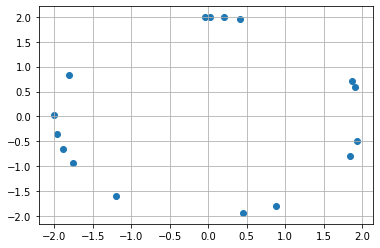

In [18]:
# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

(16, 1, 2)


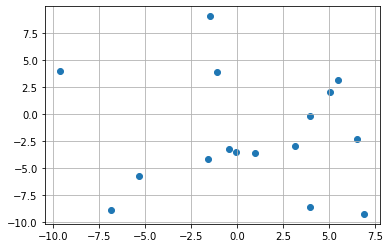

In [19]:
# for plotting learned consteallation diagram after reyliegh channel

scatter_plot = []
for i in range(0,M):
    temp = np.zeros(M)
    temp[i] = 1
    scatter_plot.append(channel_layer.predict(encoder.predict(np.expand_dims(temp,axis=0))))
scatter_plot = np.array(scatter_plot)
print (scatter_plot.shape)

# ploting constellation diagram
import matplotlib.pyplot as plt
scatter_plot = scatter_plot.reshape(M,2,1)
plt.scatter(scatter_plot[:,0],scatter_plot[:,1])
#plt.axis((-2.5,2.5,-2.5,2.5))
plt.grid()
plt.show()

In [20]:
# calculating BER
# this is optimized BER function so it can handle large number of N
# previous code has another for loop which was making it slow
EbNodB_range = list(np.arange(0,20+1,2))
ber = [None]*len(EbNodB_range)
for n in range(0,len(EbNodB_range)):
    EbNo=10.0**(EbNodB_range[n]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise_mean = 0
    no_errors = 0
    nn = N
    encoded_signal = encoder.predict(test_data) 
    final_signal = channel_layer.predict(encoded_signal)
    pred_final_signal =  decoder.predict(final_signal)
    pred_output = np.argmax(pred_final_signal,axis=1)
    no_errors = (pred_output != test_label)
    no_errors =  no_errors.astype(int).sum()
    ber[n] = no_errors / nn 
    print ('SNR:',EbNodB_range[n],'BER:',ber[n])

SNR: 0 BER: 0.9375285714285714
SNR: 2 BER: 0.9378571428571428
SNR: 4 BER: 0.9365857142857142
SNR: 6 BER: 0.9369857142857143
SNR: 8 BER: 0.9364285714285714
SNR: 10 BER: 0.9369
SNR: 12 BER: 0.9368142857142857
SNR: 14 BER: 0.9359285714285714
SNR: 16 BER: 0.9356
SNR: 18 BER: 0.9368
SNR: 20 BER: 0.9369714285714286


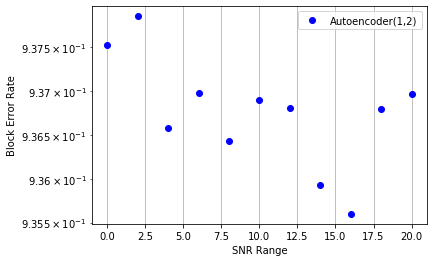

In [21]:
# ploting ber curve
import matplotlib.pyplot as plt
from scipy import interpolate
plt.plot(EbNodB_range, ber, 'bo',label='Autoencoder(1,2)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)
plt.show()

In [22]:
encoder.predict(np.expand_dims(temp,axis=0))

array([[-1.9673256, -0.3600426]], dtype=float32)

In [23]:
test=np.random.randn(10,2)
channel_layer.predict(test)

array([[ 4.075158 , -5.2729836],
       [ 2.3609977, -5.364535 ],
       [ 3.2394824, -5.2436166],
       [ 3.1437113, -5.210935 ],
       [ 3.4471285, -5.2898045],
       [ 3.5942988, -5.3369074],
       [ 3.2948194, -5.329085 ],
       [ 3.1973689, -5.3113904],
       [ 4.192924 , -5.2392592],
       [ 2.150632 , -5.3622947]], dtype=float32)